# Studying the Growth Factor

Reference: [Growth of Cosmic Structure: Probing Dark Energy Beyond Expansion](https://arxiv.org/pdf/1309.5385)

The equations governing the matter perturbations (in the Newtonian gauge) in a CDM-dominated universe are:

\begin{align}
    \delta' &= -kv - 3\Phi' \\
    v' &= -\mathcal{H}v + k\Psi \\
    k^2 \Phi &= 4\pi G a^2 \rho \left( \delta + \frac{3\mathcal{H}v}{k} \right) \\
    k^2 (\Phi + \Psi) &= 0
\end{align}

Furthermore, we can assume that
\begin{equation}
    \rho = \rho_\mathrm{cr}\Omega_m a^{-3} = \frac{3H_0^2}{8\pi G}\Omega_m a^{-3}
\end{equation}

We can use the metric equations to write the metric variables in terms of the matter perturbations variables. In particular, we know that $\Psi = - \Phi$. After lengthy calculations, we can write

\begin{equation}
    \Phi' = -\frac{\mathcal{H}C}{k^2 + 3C}\left( 1 + \frac{3C}{k^2} \right)\delta - \frac{kC}{k^2 + 3C}\left[ 1 + 3\frac{\mathcal{H}^2}{k^2} - 3\frac{\mathcal{H}' - \mathcal{H}^2}{k^2} + 9\frac{\mathcal{H^2}C}{k^4} \right]v,
\end{equation}
where
\begin{equation}
    C = \frac{3H_0^2\Omega_m}{2a}.
\end{equation}
Furthermore, we have the Friedmann equations,
\begin{align}
    \mathcal{H}^2 &= \frac{8\pi G a^2 \rho}{3}, \\
    \frac{a''}{a} = \mathcal{H}' - \mathcal{H}^2 &= -\frac{4\pi G a^2}{3}(\rho + 3P).
\end{align}

I will use units where $c$ = $8\pi G$ = $H_0$ = 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.optimize import root_scalar

In [10]:
# Constants
H0 = 1
rho_cr = 3

# Free and derived parameters
Omega_m = 0.3
Omega_r = 2.5e-5
Omega_Lambda = 1 - Omega_m - Omega_r
a_eq = Omega_r/Omega_m
w_r = 1/3
w_m = 0
w_Lambda = -1

# Initial conditions
# y = (\delta_m, v)
y0 = [1.0, 0.0] 

def rho(a):
    return rho_cr*(Omega_r*a**4 + Omega_m*a**3 + Omega_Lambda)

def P(a):
    return rho_cr*(w_r*Omega_r*a**4 + w_m*Omega_m*a**3 + w_Lambda*Omega_Lambda)

def H_curly(a):
    return a*np.sqrt(rho(a)/3)

def scale_factor_horizon_entry(k):
    # Find the value of a such that k = H_curly
    return root_scalar(lambda a: H_curly(a) - k, x0=1e-4).root

# Defining scale factor grid for integration
a_ini = 1e-7
a_switch = 1e-4
loga_int = np.linspace(np.log(a_ini), np.log(a_switch), 1000)
a_int_lin = np.linspace(a_switch, 1, 5000)
a = np.concatenate([np.exp(loga_int), a_int_lin])

# Derivative of the system with respect to scale factor
def dy_da(y, a, k=0.1):
    delta, v = y
    
    H = H_curly(a)
    rho_now = rho(a)
    P_now = P(a)
    
    kPhi = 0.5*a**2*rho_now*(delta + 3*H*v/k)/k
    
    C = 1.5*H0**2*Omega_m/a
    H_prime_minus_H2 = -a**2*(rho_now + 3*P_now)/6
    Phi_prime = -H*C/(k**2 + 3*C)*(1 + 3*C/k**2)*delta - k*C/(k**2 + 3*C)*(1 + 3*H**2/k**2 - 3*H_prime_minus_H2/k**2 - 9*H**2*C/k**4)*v
    delta_prime = -k*v
    v_prime = -H*v - kPhi
    return [delta_prime/(a*H), v_prime/(a*H)]

def dy_dloga(y, loga, k=0.1):
    a = np.exp(loga)
    deriv = dy_da(y, a, k)
    return list(map(lambda x: a*x, deriv))

def integrate(k):
    partial = odeint(dy_dloga, y0, t=loga_int, args=(k,))
    y_switch = partial[-1]
    partial2 = odeint(dy_da, y_switch, t=a_int_lin, args=(k,))
    return np.concatenate([partial, partial2])

ks = [5e-5, 1e-4, 1e-3, 1e-2]
results = [integrate(k) for k in ks]

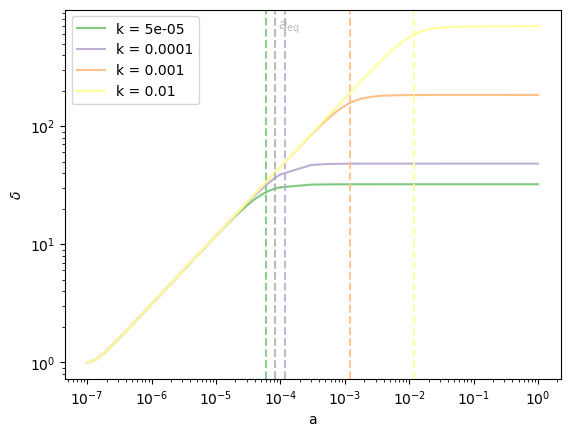

In [11]:
# From https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=6
colors = [
    "#7fc97f",
    "#beaed4",
    "#fdc086",
    "#ffff99",
    "#386cb0",
    "#f0027f"
]

for k, result, color in zip(ks, results, colors):
    delta, v = result.T
    a_horizon_entry = scale_factor_horizon_entry(k)
    plt.loglog(a, delta, label=f"k = {k}", color=color)
    plt.axvline(a_horizon_entry, alpha=0.9, ls="--", color=color)

plt.axvline(a_eq, c="darkgray", alpha=0.8, ls="--")
plt.text(a_eq*1.1, delta[-1]*0.95, r"$a_\mathrm{eq}$", c="darkgray", alpha=0.8)

plt.xlabel("a")
plt.ylabel(r"$\delta$")
plt.legend()
plt.savefig("deltas.pdf")

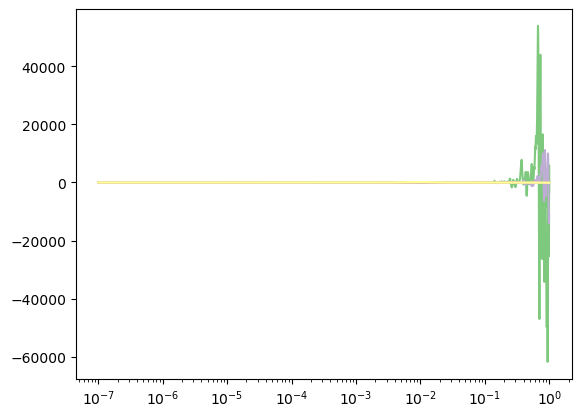

In [14]:
for k, result, color in zip(ks, results, colors):
    delta, v = result.T
    rho_a = rho(a)
    H_a = H_curly(a)
    Phi = 0.5*a**2*rho_a*(delta + 3*H_a*v/k)/k**2
    plt.semilogx(a, Phi, color=color)